# Multilayer Perceptron from CIFAR10 raw data using PyTorch

## Importing packages

In [1]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for evaluating results
from tqdm import tqdm # for progress bars
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

%matplotlib inline

In [2]:
print(f'Your torch version is {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

Your torch version is 2.6.0


device(type='mps')

## Downloading CIFAR10 dataset


In [3]:
Transform = ToTensor()
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = Transform,
    download = True
)

## Printing train_data and test_data

In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Visualization of MNIST dataset


Size: torch.Size([3, 32, 32]) Label: 6


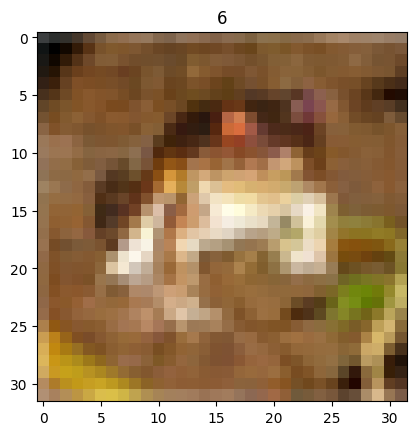

In [6]:
img, y_train = train_data[0]
print('Size:', img.size(), 'Label:', y_train)
plt.imshow(img.permute(1, 2, 0)) # to fix the TypeError: Invalid shape (1, 28, 28) for image data
plt.title('%i' % y_train)
plt.show()

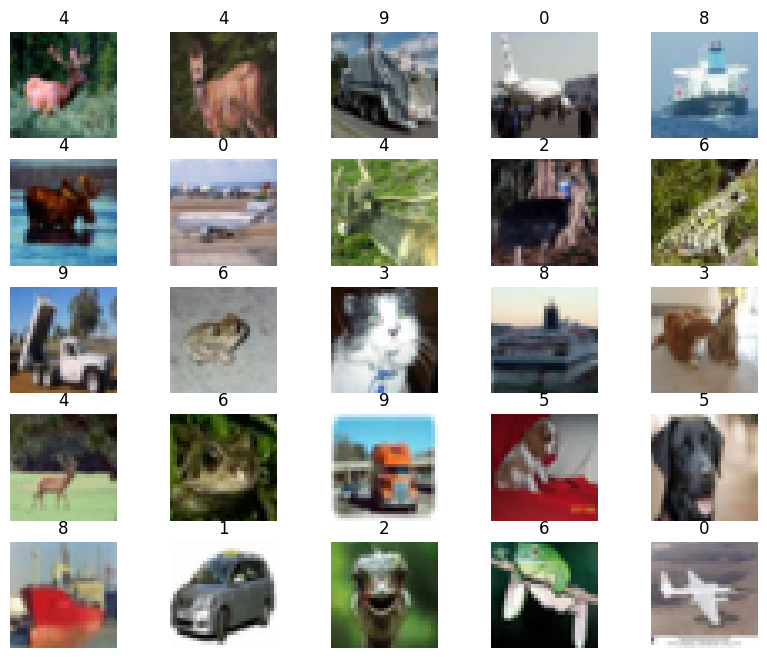

In [7]:
# Plot multiple train_data
def show_imgs(X):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(X), size=(1,)).item()
        img, label = X[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))
    plt.show()
    
show_imgs(train_data)

## Preparing data for training

In [8]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# One-layer network and weight visualisation
## Building the Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc1(x)

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0

## Training and evaluating the Model

Our model is now ready to be trained. Let's define functions to train() and validate() the model.

In [10]:
def train(epoch, model, data_loader, log_interval=200, l_norm=False):
    
    model.train()
    total_train_loss = 0
    total_correct = 0

    for batch_idx, (X_train, y_train) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        output = model(X_train)
        loss = criterion(output, y_train)
        
        # Adding L2 norm
        if l_norm:
            loss += 0.05 * sum(p.norm(2) for p in model.parameters())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, pred = torch.max(output, dim=1)
        total_correct += torch.sum(pred == y_train).item()
                  
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X_train), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    accuracy_train = total_correct / len(data_loader.dataset)
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [11]:
@torch.inference_mode()

def validate(model, data_loader):
    model.eval()
    
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).item()
        
        _, pred = torch.max(output, dim=1)
        total_correct += torch.sum(pred == target).item()

        total_preds.append(pred.detach().cpu())
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

Now we are ready to train our model using the train() function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using validate().

In [12]:
%%time
epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs+1):
    train_result = train(epoch, model, train_loader, l_norm=True)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   4%|▎         | 14/391 [00:00<00:19, 19.37it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.446665


Training Epoch 1:  56%|█████▋    | 220/391 [00:02<00:01, 124.96it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.502111


Validation: 100%|██████████| 79/79 [00:00<00:00, 107.75it/s]



Validation set: Average loss: 2.0997, Accuracy: 2998/10000 (29.98%)



Training Epoch 2:   4%|▎         | 14/391 [00:00<00:02, 133.99it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.261280


Training Epoch 2:  57%|█████▋    | 221/391 [00:01<00:01, 140.89it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.787601


Validation: 100%|██████████| 79/79 [00:00<00:00, 154.06it/s]



Validation set: Average loss: 2.3837, Accuracy: 3015/10000 (30.15%)



Training Epoch 3:   4%|▎         | 14/391 [00:00<00:02, 137.06it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.487472


Training Epoch 3:  55%|█████▌    | 217/391 [00:01<00:01, 134.90it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 3.803454


Validation: 100%|██████████| 79/79 [00:00<00:00, 144.96it/s]



Validation set: Average loss: 2.3697, Accuracy: 3058/10000 (30.58%)



Training Epoch 4:   4%|▎         | 14/391 [00:00<00:02, 137.81it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.721409


Training Epoch 4:  57%|█████▋    | 221/391 [00:01<00:01, 132.80it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.421212


Validation: 100%|██████████| 79/79 [00:00<00:00, 137.38it/s]



Validation set: Average loss: 2.6188, Accuracy: 2622/10000 (26.22%)



Training Epoch 5:   4%|▎         | 14/391 [00:00<00:02, 135.79it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 2.783800


Training Epoch 5:  53%|█████▎    | 207/391 [00:01<00:01, 134.30it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.552369


Validation: 100%|██████████| 79/79 [00:00<00:00, 154.31it/s]


Validation set: Average loss: 2.5541, Accuracy: 2648/10000 (26.48%)

CPU times: user 18.9 s, sys: 2.23 s, total: 21.1 s
Wall time: 19.3 s


## Loss and Accuracy evaluation during training

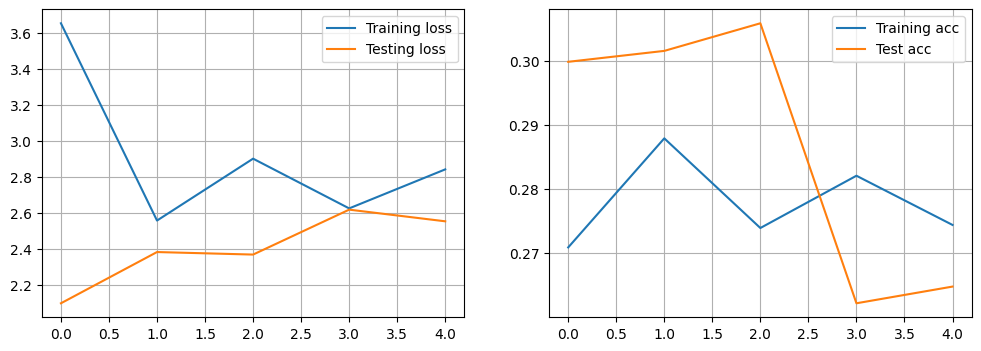

In [13]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

#### Comments

TODO

### Confusion matrix


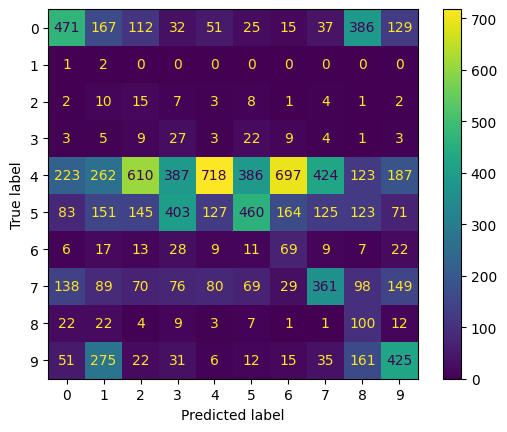

In [ ]:
cm = confusion_matrix(val_result["targets"], val_result["predictions"])

disp = ConfusionMatrixDisplay(cm)
disp.plot()

### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

Weight of classification layer has size: torch.Size([10, 3072])


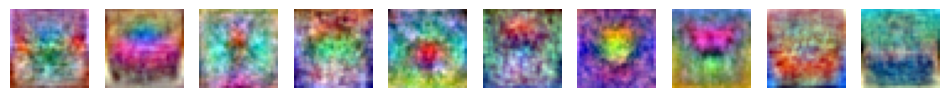

In [15]:
classifier_weight = model.fc1.weight.detach().cpu()

print(f"Weight of classification layer has size: {classifier_weight.size()}")

fig = plt.figure(figsize=(12,12))

for i, weight in enumerate(classifier_weight):
    ax = fig.add_subplot(1, 10, i+1)

    weight_reshaped = weight.view(3, 32, 32)

    min_value = weight_reshaped.amin(dim=[1, 2], keepdim=True)
    max_value = weight_reshaped.amax(dim=[1, 2], keepdim=True)
    im = ((weight_reshaped - min_value) / (max_value - min_value + 1e-5) * 255).byte().numpy()
    
    ax.axis('off')
    ax.imshow(np.transpose(im, (1, 2, 0)))

plt.show()

In [16]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

In [17]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            393,344
├─ReLU: 1-2                              --
├─Linear: 1-3                            1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            393,344
├─ReLU: 1-2                              --
├─Linear: 1-3                            1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0

In [18]:
%%time
epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs+1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   4%|▎         | 14/391 [00:00<00:07, 49.82it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301681


Training Epoch 1:  57%|█████▋    | 224/391 [00:02<00:01, 122.65it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.307711


Validation: 100%|██████████| 79/79 [00:00<00:00, 145.82it/s]



Validation set: Average loss: 2.3029, Accuracy: 1000/10000 (10.00%)



Training Epoch 2:   3%|▎         | 10/391 [00:00<00:04, 94.86it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.301731


Training Epoch 2:  57%|█████▋    | 224/391 [00:01<00:01, 125.97it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.303710


Validation: 100%|██████████| 79/79 [00:00<00:00, 149.83it/s]



Validation set: Average loss: 2.3031, Accuracy: 1000/10000 (10.00%)



Training Epoch 3:   2%|▏         | 9/391 [00:00<00:04, 87.48it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.304217


Training Epoch 3:  58%|█████▊    | 228/391 [00:01<00:01, 135.06it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.304553


Validation: 100%|██████████| 79/79 [00:00<00:00, 146.82it/s]



Validation set: Average loss: 2.3034, Accuracy: 1000/10000 (10.00%)



Training Epoch 4:   3%|▎         | 13/391 [00:00<00:02, 129.65it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.300358


Training Epoch 4:  57%|█████▋    | 224/391 [00:01<00:01, 137.42it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.302566


Validation: 100%|██████████| 79/79 [00:00<00:00, 144.42it/s]



Validation set: Average loss: 2.3027, Accuracy: 1001/10000 (10.01%)



Training Epoch 5:   3%|▎         | 13/391 [00:00<00:03, 124.24it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 2.304325


Training Epoch 5:  57%|█████▋    | 223/391 [00:01<00:01, 127.73it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.301232


Validation: 100%|██████████| 79/79 [00:00<00:00, 146.63it/s]


Validation set: Average loss: 2.3033, Accuracy: 1000/10000 (10.00%)

CPU times: user 18.8 s, sys: 1.98 s, total: 20.8 s
Wall time: 18.3 s


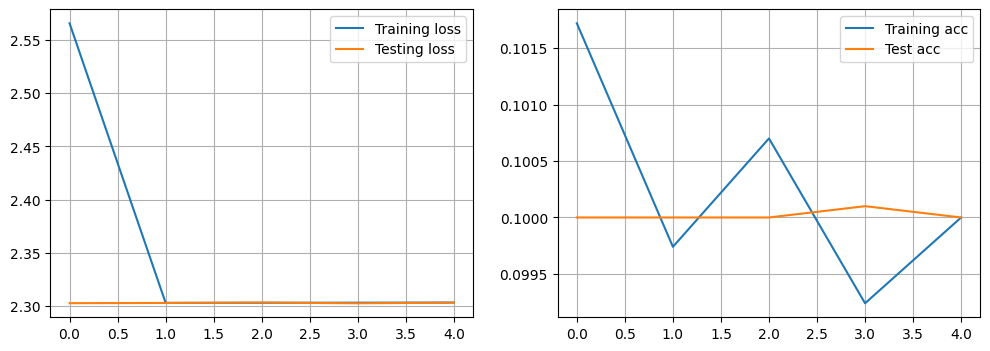

In [19]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

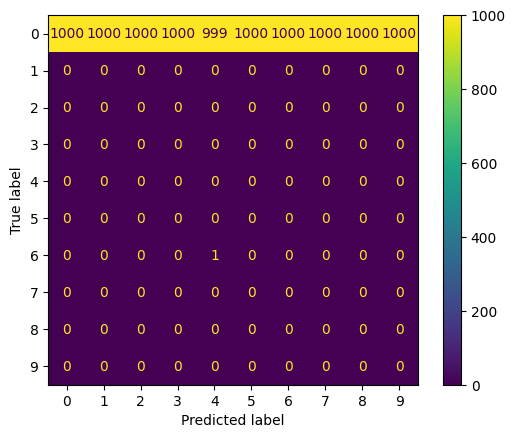

In [20]:
cm = confusion_matrix(val_result["predictions"], val_result["targets"])

disp = ConfusionMatrixDisplay(cm)
disp.plot()

Weight of classification layer has size: torch.Size([128, 3072])


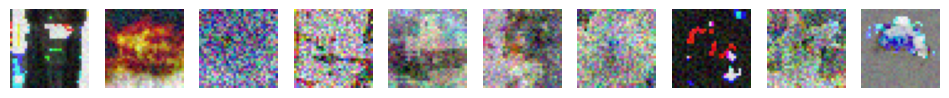

In [21]:
classifier_weight = model.fc1.weight.detach().cpu()

print(f"Weight of classification layer has size: {classifier_weight.size()}")

fig = plt.figure(figsize=(12,12))


for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)

    weight = classifier_weight[i]
    weight_reshaped = weight.view(3, 32, 32)

    min_value = weight_reshaped.amin(dim=[1, 2], keepdim=True)
    max_value = weight_reshaped.amax(dim=[1, 2], keepdim=True)
    im = ((weight_reshaped - min_value) / (max_value - min_value + 1e-5) * 255).byte().numpy()
    
    ax.axis('off')
    ax.imshow(np.transpose(im, (1, 2, 0)))

plt.show()